# Risk of death due to circulatory causes in 7 years in individuals aged 50 and older
*Jessica Irving, 22 May 2022*

**Required steps:**

- Create a prototype model estimating the risk of death due to circulatory causes within 7 years, using python
- Detail the approach you have taken
- Visualise the output of the model using an appropriate format
- Explain model selection and justification as to why this was chosen over other approaches
- Success criteria
- Highlight any current limitations in the model
- Discuss subsequent next steps

### Load packages and dataset

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sksurv.preprocessing import OneHotEncoder                 # Transform into numerical matrix with one-hot-encoding
from sksurv.util import Surv                         # Nice functions for transforming pandas df into structured array  
from fancyimpute import IterativeImputer              # MICE imputation
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, integrated_brier_score

In [2]:
df = pd.read_csv('five_lives_ml_task_data.csv')

### Exploratory data analysis and cleaning

From the steps below, we can see that: 
- **Age:** No outlandish ages, however 17% have missing data, and these individuals all have missing creatinine values as well. As age is going to be an important variable in any survival model, it's important to use imputation instead of dropping the variable.
- **Chapter:** This is only recorded for individuals with *death == true*, therefore this is an outcome and not an appropriate input for a prognostic model. However, we'll need this variable to formulate a variable recording the event of interest, circulatory death, and to evaluate competing risks of deaths from other causes.
- **Flc.grp:** This variable represents the sum of kappa and lambda split into deciles.
- **Creatinine**: Missing data - let's impute for now.
- **Kappa** and **lambda**: Used to create the flc.grp variable
- **Mgus**: Near zero variance - only 1% 'yes' rate
- **Sample.yr**: The vast majority of the sample was recruited in the late 90s - we can exploit this for an external temporal validation later on
- **Sex**: No missingness
- **Futime:** Individuals have been followed for up to 14 years.

##### Some simple counts

In [3]:
df.head()

,age,chapter,creatinine,flc.grp,kappa,lambda,mgus,sample.yr,sex,death,futime
0,97.0,Circulatory,1.7,10,5.70,4.860,no,1997,F,True,85.0
1,92.0,Neoplasms,0.9,1,0.87,0.683,no,2000,F,True,1281.0
2,94.0,Circulatory,1.4,10,4.36,3.850,no,1997,F,True,69.0
3,92.0,Circulatory,1.0,9,2.42,2.220,no,1996,F,True,115.0
4,93.0,Circulatory,1.1,6,1.32,1.690,no,1996,F,True,1039.0


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7874 entries, 0 to 7873
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         6524 non-null   float64
 1   chapter     2169 non-null   object 
 2   creatinine  6524 non-null   float64
 3   flc.grp     7874 non-null   int64  
 4   kappa       7874 non-null   float64
 5   lambda      7874 non-null   float64
 6   mgus        7874 non-null   object 
 7   sample.yr   7874 non-null   int64  
 8   sex         7874 non-null   object 
 9   death       7874 non-null   bool   
 10  futime      7874 non-null   float64
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 623.0+ KB


In [5]:
# Convert object dtypes to category for model matrix building later.
df["sex"] = df["sex"].astype("category")
df["chapter"] = df["chapter"].astype("category")
df["mgus"] = df["mgus"].astype("category")

In [6]:
df['mgus'].value_counts() # Near zero variance - implications for later modelling

no     7759
yes     115
Name: mgus, dtype: int64

In [7]:
df['flc.grp'].value_counts() 

3     820
2     811
7     806
9     803
6     791
5     791
4     786
1     769
10    767
8     730
Name: flc.grp, dtype: int64

In [8]:
df.describe(include = 'all') # 2169 events.

,age,chapter,creatinine,flc.grp,kappa,lambda,mgus,sample.yr,sex,death,futime
count,6524.000000,2169,6524.000000,7874.000000,7874.000000,7874.000000,7874,7874.000000,7874,7874,7874.000000
unique,NaN,16,NaN,NaN,NaN,NaN,2,NaN,2,2,NaN
top,NaN,Circulatory,NaN,NaN,NaN,NaN,no,NaN,F,False,NaN
freq,NaN,745,NaN,NaN,NaN,NaN,7759,NaN,4350,5705,NaN
mean,65.057787,NaN,1.093516,5.470536,1.430881,1.702624,NaN,1996.790831,NaN,NaN,3661.042291
std,10.682585,NaN,0.416507,2.863011,0.896774,1.030732,NaN,1.765156,NaN,NaN,1432.677330
min,50.000000,NaN,0.400000,1.000000,0.010000,0.040000,NaN,1995.000000,NaN,NaN,0.000000
25%,56.000000,NaN,0.900000,3.000000,0.960000,1.200000,NaN,1996.000000,NaN,NaN,2852.000000
50%,63.500000,NaN,1.000000,5.000000,1.270000,1.510000,NaN,1996.000000,NaN,NaN,4302.000000
75%,73.000000,NaN,1.200000,8.000000,1.680000,1.920000,NaN,1997.000000,NaN,NaN,4773.000000


In [9]:
df['sample.yr'].value_counts() # Vast majority recruited in late 90s. 

1996    3491
1997    1381
1995    1275
1998     687
1999     350
2000     245
2003     222
2001     175
2002      48
Name: sample.yr, dtype: int64

##### Handling correlations between features

In [10]:
df.corr()

,age,creatinine,flc.grp,kappa,lambda,sample.yr,death,futime
age,1.000000,0.116439,0.317990,0.279997,0.229881,-0.125051,0.539427,-0.405917
creatinine,0.116439,1.000000,0.259453,0.553277,0.502504,0.043304,0.157080,-0.190837
flc.grp,0.317990,0.259453,1.000000,0.703849,0.653835,0.072409,0.279271,-0.284912
kappa,0.279997,0.553277,0.703849,1.000000,0.819552,0.076069,0.284790,-0.324305
lambda,0.229881,0.502504,0.653835,0.819552,1.000000,0.002739,0.256982,-0.279041
sample.yr,-0.125051,0.043304,0.072409,0.076069,0.002739,1.000000,-0.121811,-0.315571
death,0.539427,0.157080,0.279271,0.284790,0.256982,-0.121811,1.000000,-0.639805
futime,-0.405917,-0.190837,-0.284912,-0.324305,-0.279041,-0.315571,-0.639805,1.000000


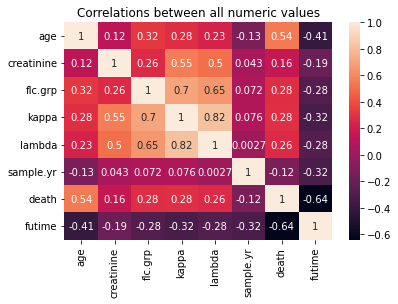

In [11]:
corrMatrix = df.corr()

sn.heatmap(corrMatrix, annot=True)
plt.title("Correlations between all numeric values")
plt.show()

*Kappa* and *lambda* are strongly correlated with eachother. From the paper and from plotting I can see that flc.grp is just the sum of kappa and lambda together, binned into deciles. I want to get rid of these arbitrary bins and return this value to its raw form, which is better practice in predictive modelling. Here I also create a new variable called kl_ratio representing the ratio between kappa and lambda, which is also indicated in the paper as of clinical importance.

As the paper also mentions potential interactive effects between the sum and the ratio of kappa to lambda, I have also created an interaction variable called *kl_interaction*.

In [12]:
df['kl_sum'] = df['kappa'] + df['lambda']
df['kl_ratio'] = df['kappa'] / df['lambda']
df['kl_interaction'] = df['kl_sum'] * df['kl_ratio']

Tabulating the correlations again, we can see that the new variables *kl_sum* and *kl_ratio* have removed the problem of collinearity posed by *kappa* and *lambda*. However, the interaction variable (as one might expect) is strongly correlated with these two variables as well as with _creatinine_. 

In [13]:
# Check correlations of new variables
df.corr()

,age,creatinine,flc.grp,kappa,lambda,sample.yr,death,futime,kl_sum,kl_ratio,kl_interaction
age,1.000000,0.116439,0.317990,0.279997,0.229881,-0.125051,0.539427,-0.405917,0.264777,0.016453,0.241215
creatinine,0.116439,1.000000,0.259453,0.553277,0.502504,0.043304,0.157080,-0.190837,0.550158,0.049788,0.480236
flc.grp,0.317990,0.259453,1.000000,0.703849,0.653835,0.072409,0.279271,-0.284912,0.709715,0.028100,0.583820
kappa,0.279997,0.553277,0.703849,1.000000,0.819552,0.076069,0.284790,-0.324305,0.947021,0.144082,0.892660
lambda,0.229881,0.502504,0.653835,0.819552,1.000000,0.002739,0.256982,-0.279041,0.960166,-0.105287,0.614574
sample.yr,-0.125051,0.043304,0.072409,0.076069,0.002739,1.000000,-0.121811,-0.315571,0.038631,0.065388,0.085910
death,0.539427,0.157080,0.279271,0.284790,0.256982,-0.121811,1.000000,-0.639805,0.282920,0.020537,0.242120
futime,-0.405917,-0.190837,-0.284912,-0.324305,-0.279041,-0.315571,-0.639805,1.000000,-0.314554,-0.041107,-0.280298
kl_sum,0.264777,0.550158,0.709715,0.947021,0.960166,0.038631,0.282920,-0.314554,1.000000,0.011249,0.779785
kl_ratio,0.016453,0.049788,0.028100,0.144082,-0.105287,0.065388,0.020537,-0.041107,0.011249,1.000000,0.541285


##### Missing data
Age and creatinine are missing for the same ~17% of individuals. I'm going to use multiple imputation later on to handle these, but I'll wait until I've split the train and test sets so there is no data leakage into the test set.

In [14]:
df.isnull().sum()

age               1350
chapter           5705
creatinine        1350
flc.grp              0
kappa                0
lambda               0
mgus                 0
sample.yr            0
sex                  0
death                0
futime               0
kl_sum               0
kl_ratio             0
kl_interaction       0
dtype: int64

##### Define new outcome variable

In [15]:
df['circ_death'] = np.where((df.death == True) & ((df.chapter == 'Circulatory')), True, False)

df.circ_death.value_counts() # 745 deaths from circulatory causes

False    7129
True      745
Name: circ_death, dtype: int64

### Estimating seven-year risk of death from circulatory cause with a Kaplan Meier curve

The estimated curve is a step function, with steps occurring at time points where one or more patients died. Probability of dying from a circulatory cause increases linearly over this time.

While patients in this dataset have been followed up for 14 years, we can estimate their risk of death at **seven years** using a KM curve. Overall, seven-year risk of death from circulatory causes is around 6.3% in this population.

Text(0.5, 15.0, '')

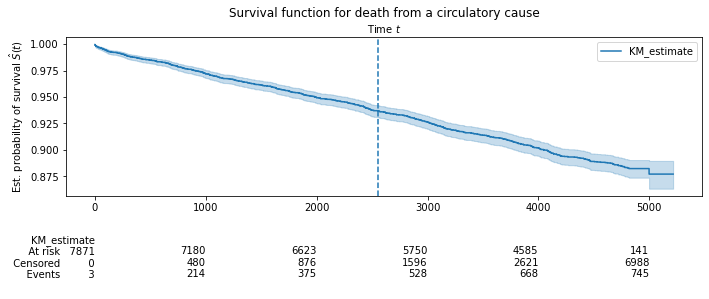

In [38]:
from matplotlib.pyplot import figure


figure(figsize=(10,4))

ax = plt.subplot(111)

kmf = KaplanMeierFitter()
kmf.fit(durations = df.futime, event_observed = df.circ_death)
kmf.plot_survival_function(ax = ax)
from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf, ax=ax)
plt.tight_layout()
plt.title('Survival function for death from a circulatory cause')
plt.ylabel("Est. probability of survival $\hat{S}(t)$")
plt.xlabel("Time $t$")
plt.axvline(x= 365.25 * 7, linestyle = 'dashed')
ax.set_ylabel("Est. probability of survival $\hat{S}(t)$")
ax.set_xlabel("")


##### How does death from a circulatory cause compare with other causes of death?
As shown in the plot below, participants in the study are more likely to die from a few other causes faster than they would from a circulatory disorder. It's not implausible that participants who die from one disorder would be more likely to die from a circulatory disorder. These 'competing risks' create problems for left censoring - discussed later in *Limitations*.

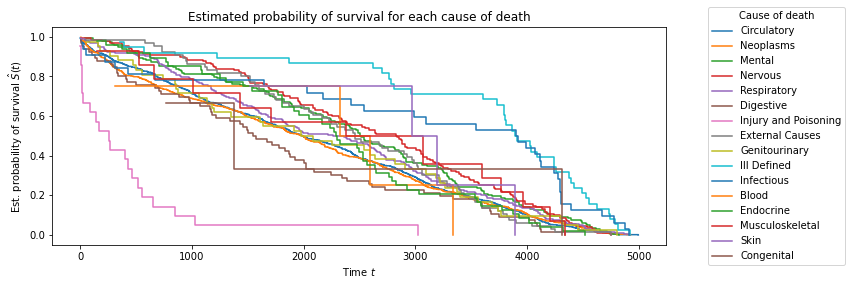

In [17]:
figure(figsize=(11,4))

chapter = df.chapter.unique()
chapter = [x for x in chapter if pd.isnull(x) == False]

for treatment_type in (chapter):
    mask_treat = df["chapter"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df["death"][mask_treat],
        df["futime"][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label= treatment_type)

plt.ylabel("Est. probability of survival $\hat{S}(t)$")
plt.xlabel("Time $t$")
plt.title("Estimated probability of survival for each cause of death")
plt.legend(title = 'Cause of death', loc="right", bbox_to_anchor = (1.3, 0.5))

# Multivariate Survival Modelling

First let's split the data into derivation (train) and validation (test) sets. 

There are numerous ways to approach this, such as randomly splitting the data in a way that ensures equivalent class balance in each group. However, an **external temporal validation** will be most robust. 

A good survival model should be flexible to developing clinical, technological and sociopolitical trends. Most of the data in this study are collected in the late 90s, so it will be particularly interesting to see how the model performs at predicting outcomes for more recent cohorts. For example, it's likely that over time there will be developments in how patients are assessed and treated, with relevant impacts on outcomes.

Allocating the last few years of data (1999 to 2003) as an external validation set will comprise around ~14% of the total data and 6% of total circulatory death events.

At the same time, we perform **a priori feature selection** using predictors previously deemed to be of importance in the literature. I'm including the kl_interaction variable despite its collinearity to see what happens.

In [18]:
exclude_years = 1999, 2000, 2001, 2002, 2003

train_y = df[df["sample.yr"].isin(exclude_years) == False].filter(['circ_death', 'futime'])

train_x = df[df["sample.yr"].isin(exclude_years) == False].filter(['age','sex','kl_sum', 'kl_ratio', 'kl_interaction', 'mgus', 'creatinine']) 

test_y = df[df["sample.yr"].isin(exclude_years)].drop(columns = ['chapter']).filter(['circ_death', 'futime'])

test_x = df[df["sample.yr"].isin(exclude_years)].drop(columns = ['chapter']).filter(['age', 'sex','kl_sum', 'kl_ratio', 'kl_interaction', 'mgus', 'creatinine'])

In [19]:
train_x

,age,sex,kl_sum,kl_ratio,kl_interaction,mgus,creatinine
0,97.0,F,10.560,1.172840,12.385185,no,1.7
2,94.0,F,8.210,1.132468,9.297558,no,1.4
3,92.0,F,4.640,1.090090,5.058018,no,1.0
4,93.0,F,3.010,0.781065,2.351006,no,1.1
5,90.0,F,3.870,1.080645,4.182097,no,1.0
...,...,...,...,...,...,...,...
7867,53.0,F,1.955,0.564000,1.102620,no,0.8
7868,52.0,F,1.816,0.763107,1.385802,no,0.7
7869,52.0,F,2.820,0.751553,2.119379,no,1.0
7872,NaN,F,4.400,0.635688,2.797026,no,NaN


In [20]:
print(f'Rows in training set = {len(train_x)}')
print(f'Rows in test set = {len(test_x)}')
print(train_y['circ_death'].value_counts()) # 704 death events
print(test_y['circ_death'].value_counts()) # 41 death events

Rows in training set = 6834
Rows in test set = 1040
False    6130
True      704
Name: circ_death, dtype: int64
False    999
True      41
Name: circ_death, dtype: int64


In [21]:
train_x = OneHotEncoder().fit_transform(train_x) # We convert categorical variables in the data set into numeric values.

test_x = OneHotEncoder().fit_transform(test_x) # We convert categorical variables in the data set into numeric values.

#### Multiple imputation of missing data

I perform multiple imputation on the train and test sets separately to avoid data leakage into the test set.

*(In a real-life scenario, I would want to explore a number of different approaches to handling missing data, but for the sake of this prototype model I will keep things simple with my usual method of choice.)*

In [22]:
# Initialize IterativeImputer
mice_imputer = IterativeImputer()

# Impute using fit_tranform on diabetes
train_x.iloc[:, :] = mice_imputer.fit_transform(train_x)
test_x.iloc[:, :] = mice_imputer.fit_transform(test_x)

In [23]:
train_y = Surv.from_dataframe("circ_death", "futime", train_y)
test_y = Surv.from_dataframe("circ_death", "futime", test_y)

## Model fitting

Survival models are indicated for longitudinal time-to-event data.

### The most interpretable choice: Cox Proportional Hazards Regression

Cox’s proportional hazard’s model is often the most appealing choice due to its high interpretability. Its coefficients can be interpreted in terms of hazard ratios, which can provide valuable insight, especially in the context of providing tailored recommendations in an app-based setting for reducing the risk conferred by individual predictors.

#### Fit the model

In [24]:
cph = CoxPHSurvivalAnalysis()
cph.fit(train_x, train_y)

CoxPHSurvivalAnalysis()

#### Evaluating proportional hazards assumption using Schoefeld Residuals
I couldn't get the requisite package to work in Python at this point, but evaluating the proportional hazards assumption is a necessary step for using a Cox proportional hazards model. Using the cox.zph() function in R I was able to determine fortunately that none of my chosen features violate the PH assumption.

#### Which variable is most predictive?

In [25]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(train_x.values, train_y)
pd.Series(scores, index= train_x.columns).sort_values(ascending=False)

age               0.805925
kl_sum            0.707229
kl_interaction    0.692091
creatinine        0.649904
kl_ratio          0.565412
sex=M             0.509742
mgus=yes          0.504773
dtype: float64

#### Additional step: Feature reduction
Here I use a grid search and k-fold cross validation (importantly, using just training data to avoid data leakage) to identify a more parsimonious model that excludes irrelevant features. Unfortunately as *age* and *creatinine* have imputed missing values, there will be some data leakage across folds. A more sophisticated development would incorporate imputation into the pipeline for each fold.

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [27]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, train_x.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(train_x, train_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
5,6,{'select__k': 6},0.829981,0.805741,0.831506,0.822409,0.011803,1,0.818623,0.831002,0.818226,0.822617,0.005931
6,7,{'select__k': 7},0.830047,0.805633,0.831304,0.822328,0.011817,2,0.818630,0.831013,0.818503,0.822715,0.005867
4,5,{'select__k': 5},0.828507,0.799439,0.826948,0.818298,0.013351,3,0.812564,0.828081,0.814207,0.818284,0.006960
3,4,{'select__k': 4},0.828222,0.799131,0.827315,0.818223,0.013505,4,0.812525,0.827412,0.814284,0.818074,0.006642
1,2,{'select__k': 2},0.827742,0.798655,0.826830,0.817742,0.013502,5,0.812258,0.826461,0.812801,0.817173,0.006571
2,3,{'select__k': 3},0.827564,0.798528,0.827012,0.817701,0.013559,6,0.812330,0.826602,0.813193,0.817375,0.006534
0,1,{'select__k': 1},0.816652,0.787469,0.816525,0.806882,0.013727,7,0.801164,0.816486,0.800859,0.806170,0.007296


We can see above that six seems to be the optimal number of predictors. Listing these below we find that the variable *mgus* has been excluded - perhaps unsurprising given its near zero variance.

Exploring a penalised model might therefore be an interesting avenue to achieve greater parsimony - however, in favour of keeping things simple and our coefficients interpretable, I will stick with the original model with features chosen *a priori* for now.

In [28]:
pipe.set_params(**gcv.best_params_)
pipe.fit(train_x, train_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

age               0.127315
sex=M             0.446660
kl_sum            0.135983
kl_ratio          0.119998
kl_interaction   -0.030930
creatinine        0.091330
dtype: float64

### Random survival forests

The downside of a Cox proportional hazards model is that it can only predict a risk score that is independent of time (due to the built-in proportional hazards assumption). 

Therefore, a single predicted risk score needs to work well for every time point. In contrast, a Random Survival Forest does not have this restriction. So let’s fit such a model to the training data.

For prediction, we do not call predict, which returns a time-independent risk score, but call predict_cumulative_hazard_function, which returns a risk function over time for each patient. We obtain the time-dependent risk scores by evaluating each cumulative hazard function at the time points we are interested in.

(NB: The model below does not use optimised parameters, as my grid search function later on sadly failed due to lack of computer processing power!)

In [39]:
rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)

rsf.fit(train_x, train_y)

RandomSurvivalForest(min_samples_leaf=7, random_state=0)

##### Grid search cross validation (not running)
(I was keen to run the below code to optimise parameters for my random survival forest model, but lacked the requisite computer processing power.)

In [40]:
#from sklearn.model_selection import GridSearchCV, KFold
#
#from sksurv.metrics import (
#    as_concordance_index_ipcw_scorer,
#    as_cumulative_dynamic_auc_scorer,
#    as_integrated_brier_score_scorer,
#)
#
#cv = KFold(n_splits=3, shuffle=True, random_state=1)
#
#cv_param_grid = {
#    "estimator__max_depth": np.arange(1, 10, dtype=int),
#}
#
#gcv_cindex = GridSearchCV(
#    as_concordance_index_ipcw_scorer(rsf, tau= brier_times[-1]),
#    param_grid = cv_param_grid,
#    cv=cv,
#    n_jobs=4,
#).fit(train_x, train_y)

##### Feature importance

Out of interest, let's compute feature importance. The result below shows that age is by far the most important feature. If its relationship to survival time is removed (by random shuffling), the concordance index on the test data drops on average by 0.16 points. 

Note: As above, there will be data leakage from age and creatinine which have already been imputed using MICE on the entire training set, therefore the permutations will not be independent of each other.

In [41]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state= 0)
perm.fit(test_x, test_y)
eli5.show_weights(perm, feature_names= train_x.columns.tolist())

Weight,Feature
0.1554 ± 0.0381,age
0.0348 ± 0.0234,creatinine
0.0272 ± 0.0219,kl_interaction
0.0064 ± 0.0155,sex=M
0.0032 ± 0.0189,kl_sum
0.0000 ± 0.0002,mgus=yes
-0.0007 ± 0.0097,kl_ratio


## Model comparison: Success criteria / measuring performance

(**NB:** While Harrell’s concordance index is often used in survival modelling, it is known to be biased upwards if the amount of censoring in the test data is high. There is huge censoring for the outcome of death from a circulatory disease and therefore Harrell'C is not appropriate. Furthermore, it is not a useful measure of performance if a specific time range is of primary interest (e.g. predicting death within 2 years.))

### Assessing discrimination: Cumulative dynamic AUC
Taking one point estimate of model performance, e.g. mean AUC overall, can obfuscate time-dependent performance. Cumulative dynamic AUC allows us to observe how each of our candidate models performs over time.

In [42]:
va_times = np.arange(8, 2520, 30) # Weekly intervals from the first week, for 7 years

In [43]:
cph_risk_scores = cph.predict(test_x)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    train_y, test_y, cph_risk_scores, va_times
)

rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    test_x, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    train_y, test_y, rsf_risk_scores, va_times
)

Prognostic ability for the Cox model is strongest in the first year. My sense is that this is a common scenario with survival models such as this that only predict from one point in time - the farther in time we get from the index features, the more that has potential to change. And let's not forget - key predictors such as age are not static over the follow-up period!

Interestingly, the RSF model performs very poorly at predicting in the short term, but shows an advantage after day 1800. It's almost as if this model needs time to 'ramp up' before prediction improves.

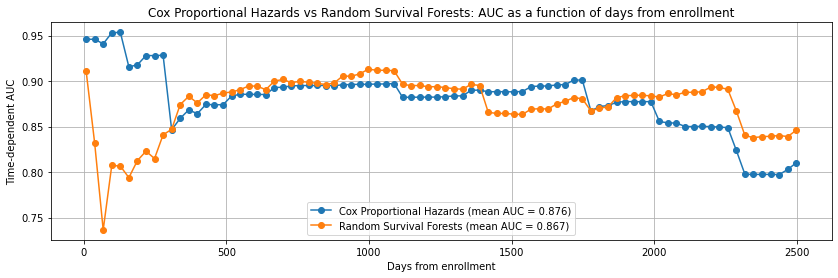

In [44]:
figure(figsize=(14,4))

plt.plot(va_times, cph_auc, "o-", label="Cox Proportional Hazards (mean AUC = {:.3f})".format(cph_mean_auc))
plt.plot(va_times, rsf_auc, "o-", label="Random Survival Forests (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.xlabel("Days from enrollment")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower center")
plt.title('Cox Proportional Hazards vs Random Survival Forests: AUC as a function of days from enrollment')
plt.grid(True)

### Assessing calibration: Time-dependent Brier score

While measuring discrimination allows us to assess the ability of the model to classify events from non-events, measuring calibration allows us to measure the distance between observed and predicted values (analogous to mean squared error in a standard regression model).

First we determine for which time points 𝑡 we want to compute the Brier score for. We select all time points between the 10% and 90% percentile of observed time points in the test set.

This returns 2773 time points, for which we need to estimate the probability of survival for, which is given by the survival function. Thus, we iterate over the predicted survival functions on the test data and evaluate each at the time points from above.

The lower the Brier score the better. Both RSF and CPH models are very well calibrated, with RSF performing slightly better.

In [45]:
lower, upper = np.percentile(test_y["futime"], [10, 90])
brier_times = np.arange(lower, upper + 1) # Returns 2773 times

rsf_surv_prob = np.row_stack([
    fn(brier_times)
    for fn in rsf.predict_survival_function(test_x)
])
cph_surv_prob = np.row_stack([
    fn(brier_times)
    for fn in cph.predict_survival_function(test_x)
])

random_surv_prob = 0.5 * np.ones(
    (test_y.shape[0], brier_times.shape[0])
)

score_brier = pd.Series(
    [
        integrated_brier_score(train_y, test_y, prob, brier_times)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob)
    ],
    index=["RSF", "CPH", "Random"],
    name="IBS"
)

score_brier

RSF       0.022069
CPH       0.022833
Random    0.186319
Name: IBS, dtype: float64

## Conclusions

From a few simple predictors it was possible to build a classifier for predicting risk of death from a circulatory disease after seven years that performed well in external temporal validation. 

Strikingly, the CPH and RSF models were stronger at predicting in the short term and long term respectively, and therefore might pose different use cases. Perhaps the models' complementary use cases could also be exploited via an ensemble modelling method. Both models were roughly equivalently well-calibrated. Interestingly, the models seem to disagree on which features aside from age are important.

One thing to note is that there were far fewer circulatory death events in the validation set than the derivation set. More investigation is needed to establish whether this is inflating model performance estimates. 

## Limitations and further avenues for investigation

1. **Competing risks: When subjects have multiple possible events in a time-to-event setting**

Unobserved dependence among event times is a fundamental problem that needs special consideration. In this study 1424 patients die from non-circulatory causes, which means they are censored. It is highly plausible that someone at risk of dying from one disorder is more likely to die from other causes, such as acirculatory disorder. 

Cumulative incidence using Kaplan-Meier is always >= cumulative incidence using competing risks methods, so can only lead to an overestimate of the cumulative incidence. The amount of overestimation will depend on event rates and dependence among events. 

*Workaround - competing risks regression:* I couldn't find a useful package in Python for this, but R has packages for handling this such as the *cmprisk* package.

2. **Non-static covariates**

Age is a key example of a covariate that changes over time and increases risk. Future work would ideally incorporate time-varying coefficients (I think this can be achieved with the *lifelines* package).


3. **Data leakage from multiple imputation into k-fold validation**

However, this won't affect the external validation here.


4. **Unable to check proportional hazards assumption**

I was unable to do this in Python, but R had an easy method of doing this.

5. **Accelerated Failure Time Model**

The Accelerated Failure Time (AFT) model is an alternative to Cox’s proportional hazards model. The latter assumes that features only influence the hazard function via a constant multiplicative factor. In contrast, features in an AFT model can accelerate or decelerate the time to an event by a constant factor. The figure below depicts the predicted hazard functions of a proportional hazards model in blue and that of an AFT model in orange.

6. **Sensitivity and specificity**

I would still like to calculate sensitivity and specificity to establish how the model performs at 'ruling in' patients at risk of death in seven years. Again, easily done in R - more investigation needed to produce this in Python as there's no intuitive package.

7. **Lifelines package**

I only lightly delve into this package here, but it has a lot of additional functions relevant to survival modelling that I am keen to try out.